# LaneLines by Manuel Quinteiro

## Importing libreries


In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import sys
import os
import math
%matplotlib inline
os.listdir("test_images/")

['solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'solidWhiteCurve.jpg',
 'solidYellowCurve.jpg',
 'solidWhiteRight.jpg',
 'whiteCarLaneSwitch.jpg']

## Helper functions 

In [2]:
#function to calculate the slope of lines
def slopeLine(line):
    start = np.array([line[0], line[1]])
    end = np.array([line[2], line[3]])

    if abs(start[0] - end[0]) < sys.float_info.epsilon:
        return sys.float_info.max
    return (start[1] - end[1]) / (start[0] - end[0])

#function to calculate the intersection between two lines
def intersectionPoint(line1, line2):
    s1 = np.array([line1[0],line1[1]])
    e1 = np.array([line1[2],line1[3]])
    s2 = np.array([line2[0], line2[1]])
    e2 = np.array([line2[2], line2[3]])

    slope1 = (s1[1] - e1[1]) / (s1[0] - e1[0])
    slope2 = (s2[1] - e2[1]) / (s2[0] - e2[0])
    b1 = s1[1] - (slope1 * s1[0])
    b2 = s2[1] - (slope2 * s2[0])

    if abs(slope1 - slope2) < sys.float_info.epsilon:
        return False

    x = (b2 - b1) / (slope1 - slope2)
    y = slope1 * x + b1
    return (x, y)

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)


def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)


def region_of_interest(img, vertices):
    """
    Applies an image mask.

    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    # defining a blank mask to start with
    mask = np.zeros_like(img)

    # defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    # filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    # returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

Redefinition of draw_lines it use a horizontal line to search for lane lines, additionale take care about slopes and have memory for errors in the video images.

In [3]:
def draw_lines2(img, lines, color=[255, 0, 0], cutingLine=450, thickness=2):
    #global variables for memory proposes
    global leftFails
    global rightFails
    global maxSlope
    global lastRightLine
    global lastLeftLine
    global lastLeftSlope
    global lastRightSlope
    global validRightSlopeCount
    global validLeftSlopeCount
    global lastLeftInt
    global lastRightInt

    #we will pay attention to the lines that cross a line in the image
    cv2.line(img, (0, cutingLine), (image.shape[1], cutingLine), color, thickness)
    mid=image.shape[1]/2
    left=0
    right=image.shape[1]
    rightLine=None
    leftLine=None
    if lines is None:
        return False
    for line in lines:

        for x1, y1, x2, y2 in line:
            if (y1 < cutingLine and y2 < cutingLine):
                continue
            slope = slopeLine(line[0]);
            #inter=intersectionPoint(line[0],[0,image.shape[0],image.shape[1],image.shape[0]])
            inter = intersectionPoint(line[0], [0, cutingLine, image.shape[1], cutingLine])
            if(inter ==False):
                continue
            #Check if intersection is inside the line
            if(inter[1]>y1 and inter[1]>y2) or (inter[1]<y1 and inter[1]<y2):
                continue
            #now we take closser line from right and closser from left
            if (inter[0]>mid and inter[0]<right):
                if abs(slope)<maxSlope/100:
                    continue
                # right
                if validRightSlopeCount and (lastRightSlope/slope < 0.92 or lastRightSlope/slope > 1.08 or abs(lastRightInt-inter[0])>15):
                    continue
                right=inter[0]
                rightLine=line[0]
            if (inter[0]<mid and inter[0]>left):
                #left
                if abs(slope)<maxSlope/100:
                    continue
                if validLeftSlopeCount and ((lastLeftSlope/slope < 0.92 ) or lastLeftSlope/slope > 1.08 or abs(lastLeftInt-inter[0])>15):
                    continue

                left=inter[0]
                leftLine=line[0]

    #if we have found a image that fit all requirements we write it, if not we use the last information during
    # maxHisteresys frames
    if leftLine is not None:
        cv2.line(img, (leftLine[0], leftLine[1]), (leftLine[2], leftLine[3]), color, thickness)
        lastLeftLine=leftLine
        lastLeftSlope=slopeLine(leftLine)
        lastLeftInt= intersectionPoint(leftLine, [0, cutingLine, image.shape[1], cutingLine])[0]
        if(validLeftSlopeCount<maxHisteresys):
            validLeftSlopeCount+=1

    else:
        leftFails+=1
        if (validLeftSlopeCount > 0):
            leftFails -= 1
            validLeftSlopeCount -= 1
            cv2.line(img, (lastLeftLine[0], lastLeftLine[1]), (lastLeftLine[2], lastLeftLine[3]), color, thickness)

    if rightLine is not None:
        cv2.line(img, (rightLine[0], rightLine[1]), (rightLine[2], rightLine[3]), color, thickness)
        lastRightLine = rightLine
        lastRightSlope = slopeLine(rightLine)
        lastRightInt = intersectionPoint(rightLine, [0, cutingLine, image.shape[1], cutingLine])[0]
        if (validRightSlopeCount < maxHisteresys):
            validRightSlopeCount += 1
    else:
        rightFails += 1
        if (validRightSlopeCount > 0):
            rightFails -= 1
            validRightSlopeCount -= 1
            cv2.line(img, (lastRightLine[0], lastRightLine[1]), (lastRightLine[2], lastRightLine[3]), color, thickness)

The old draw_lines is maintained but not used, and some more helper functions

In [4]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).

    Think about things like separating line segments by their
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of
    the lines and extrapolate to the top and bottom of the lane.

    This function draws `lines` with `color` and `thickness`.
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap,linecutPos=0):
    """
    `img` should be the output of a Canny transform.

    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len,maxLineGap=max_line_gap)
    #lines = cv2.HoughLines(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len,maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    if(linecutPos>0):
        draw_lines2(line_img, lines,color=[0,0,255],cutingLine=linecutPos,thickness=4)
    else:
        draw_lines(line_img,lines)

    return line_img


# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.

    `initial_img` should be the image before any processing.

    The result image is computed as follows:

    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)


#new function to limit the pixels of the image. It work fine but I dont know if it is a good idea,
#could generate new edges.
def removeColors(initial_img, red_threshold, green_threshold, blue_threshold):
    rgb_threshold = [red_threshold, green_threshold, blue_threshold]
    color_select = np.copy(image)
    thresholds1 = image[:, :, 0] < rgb_threshold[0]
    thresholds2 = image[:, :, 1] < rgb_threshold[1]
    thresholds3 = image[:, :, 2] < rgb_threshold[2]
    thresholds = (thresholds1*1+thresholds2*1+thresholds3*1)>1
    color_select[thresholds] = [0, 0, 0]
    return color_select

## Main code starts here

starting with initialitation
The cv2 code will open a new window with the video. some screenshots are pasted at the end

In [5]:
#configuration variables
#videoName="test_videos/solidWhiteRight.mp4"
videoName="test_videos/challenge.mp4"
videoImages=True
debug=0
lightLimit=221
maxSlope=24
lthres=0
mthres=255
frames=0
validSlopeCount=0
lastSlope=0
lastValidSlope=None
pause=False
leftFails=0
rightFails=0
validLeftSlopeCount=0
validRightSlopeCount=0
maxHisteresys = 20
lastLeftInt=0
lastRightInt=2000
hough_maxLen=180

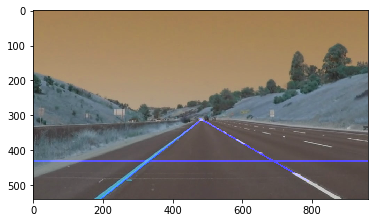

In [6]:
#creating statics images
imageFiles = os.listdir("test_images/")
maxHisteresys=0
for imageName in imageFiles:
    image = cv2.imread('test_images/'+imageName)
    uncolored = removeColors(image, lightLimit/3, lightLimit, lightLimit)
    uncolored[0:int(image.shape[0]/2), :] = 0
    withCanny = cv2.Canny(uncolored, lthres, mthres)
    hough_image = hough_lines(withCanny, 1,2*( np.pi / 180.0), 25, 10, hough_maxLen, int(image.shape[0]/5)*4)
    final = weighted_img(hough_image, image, 0.8, 1., 0.)
    cv2.imwrite("test_images_output/"+imageName,final)
    plt.imshow(final)

In [ ]:
maxHisteresys =10
cap = cv2.VideoCapture(videoName)
cv2.namedWindow("Final", 1)
if debug:
    cv2.createTrackbar('lightLimit', 'Final', lightLimit, 255, tracbarRersponse)
    cv2.createTrackbar('slope', 'Final', maxSlope, 1000, tracbarRersponse)
    cv2.createTrackbar('lthres', 'Final', lthres, 255, tracbarRersponse)
    cv2.createTrackbar('mthres', 'Final', mthres, 255, tracbarRersponse)
idx=0
scrIdx=0
#start with video processing (or debuging static images)

while(True):
    if videoImages is True:
        if pause is not True:
            ret, image =  cap.read()
        if ret == False:
            #coment break stament if you want to remeat for ever.
            cv2.destroyAllWindows()
            break
            cap = cv2.VideoCapture(videoName)
            leftFails = 0
            rightFails = 0
            frames = 0
            continue
    else:
        image = cv2.imread('test_images/'+imageFiles[idx])

    frames +=1

    #this is the algorithm cleaning images, do canny process and hought_lines, finale merge with original image
    uncolored = removeColors(image, lightLimit/3, lightLimit, lightLimit)

    uncolored[0:int(image.shape[0]/2), :] = 0

    withCanny = cv2.Canny(uncolored, lthres, mthres)

    hough_image = hough_lines(withCanny,1,np.pi/180,25,10,hough_maxLen,int(image.shape[0]/5)*4)
    final = weighted_img(hough_image, image, 0.8, 1., 0.)

    #show debug information
    if debug:
        lthres=cv2.getTrackbarPos('lthres', 'Final')
        mthres = cv2.getTrackbarPos('mthres', 'Final')
        lightLimit = cv2.getTrackbarPos('lightLimit', 'Final')
        maxSlope = cv2.getTrackbarPos('slope', 'Final')

        full_image = np.zeros((image.shape[0] * 2, image.shape[1] * 2, 3), np.uint8)
        #uncolored.copyTo(full_image.submat(0,0,image.shape[0]-1,image.shape[1]-1))
        full_image[0:image.shape[0],0:image.shape[1]]=uncolored
        full_image[image.shape[0]:image.shape[0]+image.shape[0], 0:image.shape[1],0] = withCanny
        full_image[0:image.shape[0], image.shape[1]:image.shape[1]+image.shape[1]] = hough_image
        full_image[image.shape[0]:image.shape[0]+image.shape[0], image.shape[1]:image.shape[1] + image.shape[1]] = final
        cv2.putText(full_image,"leftFails = "+ str(leftFails),(0,120),0,2,[255,0,0],3)
        cv2.putText(full_image, "rightFails = " + str(rightFails), (0, 160), 0, 2, [255, 0, 0], 3)
        cv2.putText(full_image, "leftHist = " + str(validLeftSlopeCount), (1000, 120), 0, 2, [255, 0, 0], 3)
        cv2.putText(full_image, "rightHist = " + str(validRightSlopeCount), (1000, 160), 0, 2, [255, 0, 0], 3)
        cv2.putText(full_image, "frames = " + str(frames), (0, 200), 0, 2, [255, 0, 0], 3)
        cv2.imshow("Final", cv2.resize(full_image, (0,0), fx=0.5, fy=0.5) )
    else:

        cv2.imshow("Final", final)


    #keyboard shortcuts.
    key =cv2.waitKey(1)
    if key>0 and chr(key)=='q':
        cv2.destroyAllWindows()
        break
    if key>0 and chr(key)=='p':
        pause=True
        idx+=1
    if key > 0 and chr(key) == 'c':
        pause=False
    if key > 0 and chr(key) == 's':
        scrIdx+=1
        cv2.imwrite("test_images_output/video" + str(scrIdx) + ".png", final)

![example1](./test_images_output/video1.png)
![example2](./test_images_output/video5.png)
![example3](./test_images_output/solidYellowLeft.jpg)
